In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [ ]:
from google.colab import drive
import glob
drive.mount('/content/drive')

# folder_path = '/content/drive/MyDrive/CE252DATA/2017'  # replace with your folder path
# folder_path = '/content/drive/MyDrive/MyFolder/CE-252/'
folder_path = '/content/drive/MyDrive/CE 252 project/code/2017 Survey/'

figure_path = os.path.join(folder_path, 'figures/')

# List all CSV files in the folder
csv_files = glob.glob(os.path.join(folder_path, '*.csv'))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Regression

In [ ]:
def fit(X, y):
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
    model = LinearRegression(fit_intercept=True)
    model.fit(X_train, y_train)
    coef = [np.round(model.intercept_, 3)] + np.round(model.coef_, 3).tolist()
    print("R^2=", r2_score(y_valid, model.predict(X_valid)))
    X_copy = X.copy()
    X_copy['elasticity'] = model.coef_[0] + model.coef_[-1] * X_copy['ln_INC']
    return X_copy, coef

In [ ]:
i = 1  # strategy id (0, 1, 2, 3)

df = pd.read_csv(os.path.join(folder_path, f'Strategy{i}_CPM.csv'))

# assert df.shape[0] == df_new.shape[0]
df['Relative Delta CPM'] = df['Delta_CPM'] / df['CPM_old']
print(df.shape)
df = df[df['VMT'] > 0]
print(df.shape)

transform_dict = {1: 5000, 2: 12500, 3:20000, 4:30000, 5:42500, 6:67500, 7:87500, 8:112500, 9:137500, 10:175000, 11:400000}
df['INC'] = df['INC'].replace(transform_dict)

df['ttcost_old'] = df['VMT'] * df['CPM_old']
df['ln_VMT'] = np.log(df['VMT'] + 1e-3)
df['ln_CPM_new'] = np.log(df['CPM_new'] + 1e-3)
df['ln_INC'] = np.log(df['INC'] + 1e-3)
df['ln_W'] = np.log(df['W'] + 1e-3)
df['ln_CPM_INC'] = df['ln_CPM_new'] * df['ln_INC']
df['U'] = df['URBRUR_DESC'].apply(lambda x: 1 if x == 'Urban' else 0)
V_agg_dict = df.groupby('HOUSEID')['VEHID'].count().to_dict()
df['V'] = df['HOUSEID'].replace(V_agg_dict)

df_urban = df[df['U'] == 1].index
df_rural = df[df['U'] == 0].index

X = df[['ln_CPM_new', 'ln_INC', 'ln_W', 'U', 'V', 'ln_CPM_INC']]
y = df['ln_VMT']
_, coef_general = fit(X, y)
X_urban, coef_urban = fit(X.loc[df_urban], y.loc[df_urban])
X_rural, coef_rural = fit(X.loc[df_rural], y.loc[df_rural])

pd.DataFrame([coef_general, coef_urban, coef_rural], index=['general', 'urban', 'rural'])

(37672, 22)
(36815, 22)
R^2= 0.10070969591719481
R^2= 0.09440541755184506
R^2= 0.08752041719351311


,0,1,2,3,4,5,6
general,3.464,-2.060,0.511,0.078,-0.042,-0.273,0.179
urban,3.565,-2.077,0.504,0.081,0.000,-0.282,0.183
rural,5.443,-0.660,0.324,0.066,0.000,-0.284,0.048


## Elasticity

In [ ]:
X_combined = pd.concat([X_urban, X_rural], axis=0)
X_combined.pivot_table(values='elasticity', index='ln_INC', columns='U', aggfunc="mean").rename(columns={0:'rural', 1:'urban'}).round(3)

U,rural,urban
ln_INC,,
8.517193,-0.251,-0.518
9.433484,-0.207,-0.351
9.903488,-0.184,-0.265
10.308953,-0.165,-0.191
10.657259,-0.148,-0.127
11.119883,-0.126,-0.042
11.379394,-0.113,0.005
11.630709,-0.101,0.051
11.831379,-0.092,0.088


## VMT Change

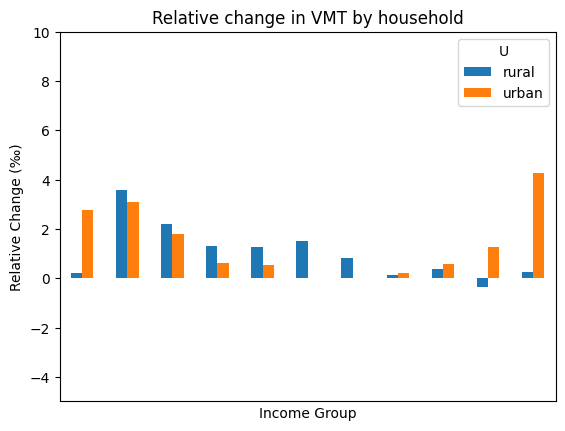

In [ ]:
result = pd.merge(X_combined, df[['Relative Delta CPM', 'VMT', 'VMT_RATE', 'HOUSEID', 'ttcost_old']], left_index=True, right_index=True, how='inner')

result['VMT_new'] = result['VMT'] * (result['Relative Delta CPM'] * result['elasticity'] + 1)
result['Change_VMT'] = result['Relative Delta CPM'] * result['elasticity'] * 1000
result['Cost_per_veh_new'] = result['VMT_new'] * result['VMT_RATE']
result['Cost_per_veh'] = result['VMT'] * result['VMT_RATE']
df_hh = result.groupby(['HOUSEID', 'ln_INC', 'U'])[['Cost_per_veh', 'Cost_per_veh_new', 'ttcost_old']].sum().reset_index().rename(columns={'Cost_per_veh':'Cost_per_hh', 'Cost_per_veh_new':'Cost_per_hh_new', 'ttcost_old': 'Cost_per_hh_old'})

df_VMT_changed = result.groupby(['HOUSEID', 'ln_INC', 'U'])['Change_VMT'].sum().reset_index()

df_VMT_changed.pivot_table(values='Change_VMT', index='ln_INC', columns='U', aggfunc="mean").rename(columns={0:'rural', 1:'urban'}).plot(kind='bar')
plt.xticks([])
plt.xlabel('Income Group')
plt.ylim(-5, 10)
plt.ylabel('Relative Change (‰)')
plt.title('Relative change in VMT by household')
plt.savefig(os.path.join(figure_path, f'VMT_change_Strategy{i}.jpg'))

## Tax burden

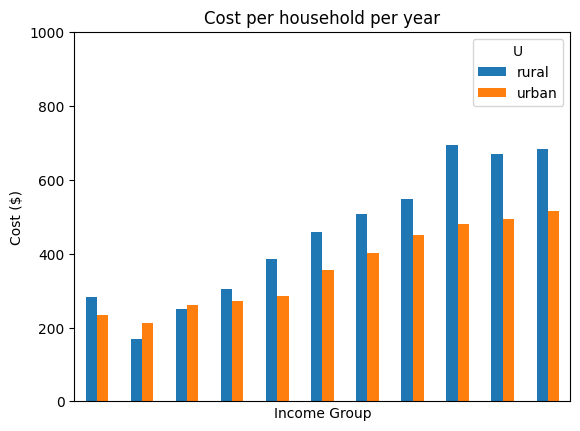

U,rural,urban
ln_INC,,
8.517193,282.151021,233.628571
9.433484,170.205813,212.387723
9.903488,250.798975,261.913060
10.308953,304.222406,271.730197
10.657259,385.646216,285.606693
11.119883,459.295443,354.645002
11.379394,506.228661,402.605286
11.630709,548.480525,450.587329
11.831379,692.744059,481.135718


<Figure size 640x480 with 0 Axes>

In [ ]:
table_5_case_3 = df_hh.pivot_table(values='Cost_per_hh_new', index='ln_INC', columns='U', aggfunc="mean").rename(columns={0:'rural', 1:'urban'})
table_5_case_3.plot(kind='bar')
plt.xticks([])
plt.ylim(0, 1000)
plt.xlabel('Income Group')
plt.ylabel('Cost ($)')
plt.title('Cost per household per year')
plt.show()
plt.savefig(os.path.join(figure_path, f'cost_Strategy{i}.jpg'))

table_5_case_3

# Comparison Analysis


In [ ]:
def process_strategy_data(file_name, strategy_label, folder_path):
    df = pd.read_csv(os.path.join(folder_path, file_name))
    df = df[df['VMT'] > 0].copy()
    df['Relative Delta CPM'] = df['Delta_CPM'] / df['CPM_old']
    transform_dict = {1: 5000, 2: 12500, 3:20000, 4:30000, 5:42500,
                      6:67500, 7:87500, 8:112500, 9:137500, 10:175000, 11:400000}
    df['INC_Value'] = df['INC'].replace(transform_dict)
    df['ln_VMT'] = np.log(df['VMT'])
    df['ln_CPM_new'] = np.log(df['CPM_new'])
    df['ln_INC'] = np.log(df['INC_Value'])
    df['ln_W'] = np.log(df['W'] + 1e-3)
    df['ln_CPM_INC'] = df['ln_CPM_new'] * df['ln_INC']
    df['U'] = df['URBRUR_DESC'].apply(lambda x: 1 if x == 'Urban' else 0)
    V_agg_dict = df.groupby('HOUSEID')['VEHID'].count().to_dict()
    df['V'] = df['HOUSEID'].map(V_agg_dict)

    def fit_model(sub_df):
        if sub_df.empty: return sub_df, [0]*6
        X = sub_df[['ln_CPM_new', 'ln_INC', 'ln_W', 'U', 'V', 'ln_CPM_INC']]
        y = sub_df['ln_VMT']
        X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
        model = LinearRegression(fit_intercept=True)
        model.fit(X_train, y_train)
        coef_cpm = model.coef_[0]
        coef_inter = model.coef_[-1]

        sub_df = sub_df.copy()
        sub_df['elasticity'] = coef_cpm + coef_inter * sub_df['ln_INC']

        return sub_df

    df_urban = fit_model(df[df['U'] == 1])
    df_rural = fit_model(df[df['U'] == 0])
    df_combined = pd.concat([df_urban, df_rural])

    # Calculate household total cost
    cols_needed = ['VMT', 'VMT_RATE', 'CPM_old', 'Relative Delta CPM', 'HOUSEID', 'INC_Value', 'U']
    result = df_combined.join(df[cols_needed], how='inner', lsuffix='_reg')
    result['VMT_new'] = result['VMT'] * (result['Relative Delta CPM'] * result['elasticity'] + 1)
    result['Cost_veh_old'] = result['VMT'] * result['CPM_old']
    result['Cost_veh_new'] = result['VMT_new'] * result['VMT_RATE']

    df_hh = result.groupby(['HOUSEID', 'INC_Value', 'U'])[['Cost_veh_old', 'Cost_veh_new']].sum().reset_index()
    df_hh.rename(columns={'Cost_veh_old': 'Cost_Old', 'Cost_veh_new': 'Cost_New'}, inplace=True)

    df_hh['Strategy'] = strategy_label
    df_hh['Burden_Pct_Old'] = (df_hh['Cost_Old'] / df_hh['INC_Value']) * 100
    df_hh['Burden_Pct_New'] = (df_hh['Cost_New'] / df_hh['INC_Value']) * 100
    df_hh['Diff_Cost'] = df_hh['Cost_New'] - df_hh['Cost_Old']

    return df_hh

files = ['Strategy0_CPM.csv', 'Strategy1_CPM.csv', 'Strategy2_CPM.csv', 'Strategy3_CPM.csv']
labels = ['Pilot Strategy', 'Strategy 1', 'Strategy 2', 'Strategy 3']

results_list = []

for f, lbl in zip(files, labels):
    try:
        df_res = process_strategy_data(f, lbl, folder_path)
        results_list.append(df_res)
    except Exception as e:
        print(f"Error processing {f}: {e}")

df_all = pd.concat(results_list, ignore_index=True)
df_baseline = results_list[0].copy()
df_baseline['Strategy'] = 'Current Tax'
df_baseline['Cost_New'] = df_baseline['Cost_Old']
df_baseline['Burden_Pct_New'] = df_baseline['Burden_Pct_Old']
df_baseline['Diff_Cost'] = 0

df_all.head()

Processing Pilot Strategy...
Processing Strategy 1...
Processing Strategy 2...
Processing Strategy 3...
Data processing complete.


,HOUSEID,INC_Value,U,Cost_Old,Cost_New,Strategy,Burden_Pct_Old,Burden_Pct_New,Diff_Cost
0,30000041,400000,1,1357.900000,431.988914,Pilot Strategy,0.339475,0.107997,-925.911086
1,30000085,137500,1,462.739130,48.621384,Pilot Strategy,0.336538,0.035361,-414.117746
2,30000227,67500,1,91.750000,9.294573,Pilot Strategy,0.135926,0.013770,-82.455427
3,30000328,400000,1,2797.763333,316.851143,Pilot Strategy,0.699441,0.079213,-2480.912190
4,30000400,30000,1,2752.500000,279.958086,Pilot Strategy,9.175000,0.933194,-2472.541914


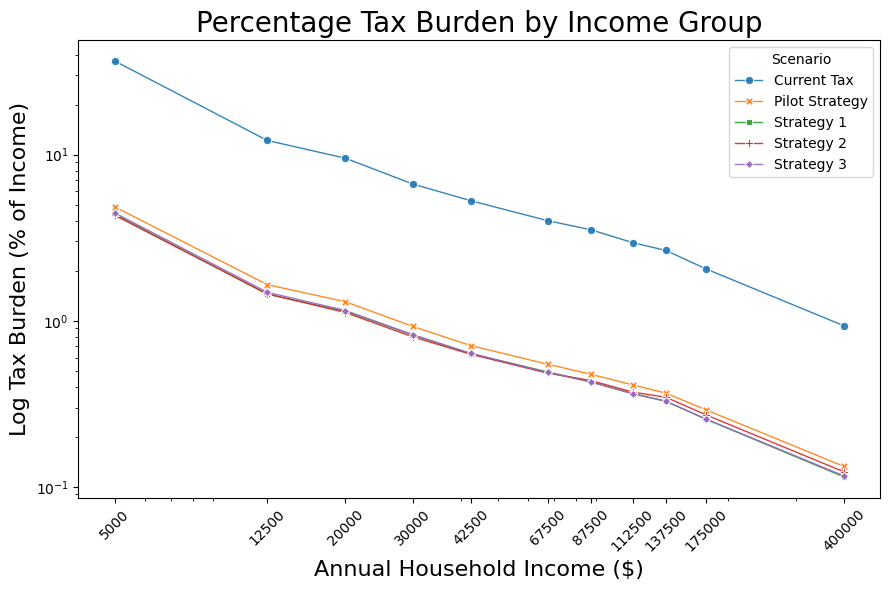

In [ ]:
# Vertical Equity
fig, ax1 = plt.subplots(figsize=(9, 6))

plot_data_vertical = pd.concat([df_baseline, df_all], ignore_index=True)
vertical_summary = plot_data_vertical.groupby(['INC_Value', 'Strategy'])['Burden_Pct_New'].agg("mean").reset_index()

sns.lineplot(data=vertical_summary, x='INC_Value', y='Burden_Pct_New', hue='Strategy',
             style='Strategy', markers=True, dashes=False, linewidth=1, ax=ax1, alpha=0.9)

ax1.set_title('Percentage Tax Burden by Income Group', fontsize=20)
ax1.set_xlabel('Annual Household Income ($)', fontsize=16)
ax1.set_ylabel('Log Tax Burden (% of Income)', fontsize=16)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xticks(sorted(vertical_summary['INC_Value'].unique()))
ax1.set_xticklabels(sorted(vertical_summary['INC_Value'].unique()), rotation=45)
# ax1.set_ylim(0, 5)
ax1.legend(title='Scenario')

plt.tight_layout()
plt.show()


/tmp/ipython-input-3930788854.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x='Scenario', y='Total Gini', data=gini_df, palette=colors, ax=ax, width=0.5)


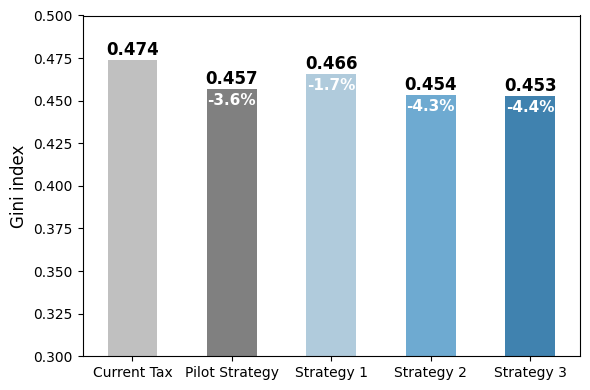

,Scenario,Total Gini,Urban Gini,Rural Gini,% Change (Total)
0,Current Tax,0.474,0.472,0.466,0.000
1,Pilot Strategy,0.457,0.457,0.448,-3.576
2,Strategy 1,0.466,0.465,0.455,-1.702
3,Strategy 2,0.454,0.454,0.445,-4.279
4,Strategy 3,0.453,0.450,0.441,-4.418


In [ ]:
# Gini index
def gini(array):
    array = np.sort(np.array(array, dtype=np.float64))
    array = array[array > 0]
    if array.size == 0: return 0

    index = np.arange(1, array.shape[0] + 1)
    n = array.shape[0]

    return ((2 * index - n - 1) * array).sum() / (n * array.sum())

df_baseline_calc = df_baseline.copy()
df_baseline_calc['Strategy'] = 'Current Tax'

df_final_calc = pd.concat([df_baseline_calc, df_all], ignore_index=True)

gini_results = []

strategies = ['Current Tax', 'Pilot Strategy', 'Strategy 1', 'Strategy 2', 'Strategy 3']

for strat in strategies:
    subset = df_final_calc[df_final_calc['Strategy'] == strat]
    cost_values = subset['Cost_New'].values

    g_total = gini(cost_values)
    g_urban = gini(subset[subset['U'] == 1]['Cost_New'].values)
    g_rural = gini(subset[subset['U'] == 0]['Cost_New'].values)

    gini_results.append({
        'Scenario': strat,
        'Total Gini': g_total,
        'Urban Gini': g_urban,
        'Rural Gini': g_rural
    })
gini_df = pd.DataFrame(gini_results)

base_gini = gini_df.loc[0, 'Total Gini']
gini_df['% Change (Total)'] = (gini_df['Total Gini'] - base_gini) / base_gini * 100

fig, ax = plt.subplots(figsize=(6, 4))

colors = ['#C0C0C0', '#808080', '#A9CCE3', '#5DADE2', '#2E86C1']
bars = sns.barplot(x='Scenario', y='Total Gini', data=gini_df, palette=colors, ax=ax, width=0.5)


ax.set_ylim(0.3, 0.5)
for i, p in enumerate(bars.patches):
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 0.0005,
            f'{height:.3f}',
            ha="center", va="bottom", fontsize=12, fontweight='bold')

    if i > 0:
        change_val = gini_df.loc[i, '% Change (Total)']
        ax.text(p.get_x() + p.get_width() / 2., height - 0.0025,
                f'{change_val:.1f}%',
                ha="center", va="top", color='white', fontsize=11, fontweight='bold')

ax.set_ylabel('Gini index', fontsize=12)
ax.set_xlabel('', fontsize=12)

plt.tight_layout()
plt.show()

gini_df.round(3)